<a href="https://colab.research.google.com/github/dohyeonYoon/Paper-review/blob/main/SENet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import Library , call Dataset 

In [ ]:
from keras.layers import Input, Conv2D, MaxPooling2D, Dropout, BatchNormalization, Dense, Activation, add, Flatten, GlobalAveragePooling2D, Reshape, multiply
from keras.models import Model

import numpy as np
import tensorflow as tf
from keras.utils import np_utils

width = 32
height = 32

(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()


170500096/170498071 [==============================] - 3s 0us/step


In [ ]:
y_train.shape

(50000, 1)

In [ ]:
num_classes = 10
y_train = np_utils.to_categorical(y_train)
y_test = np_utils.to_categorical(y_test)

In [ ]:
y_train.shape

(50000, 10)

In [ ]:
validation_images, validation_labels = x_train[:500], y_train[:500]
train_images, train_labels = x_train[500:], y_train[500:]

In [ ]:
y_train.shape

(50000, 10)

In [ ]:
def Residual_Block(x, filter):

    x_skip = x 
    f= filter

    x = Conv2D(f, kernel_size=(3,3), strides=1, padding='same')(x) 
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Conv2D(f, kernel_size=(3,3), strides=1, padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x_skip = Conv2D(f, kernel_size=(1,1),strides=(1,1),padding='same')(x_skip)
    x_skip = BatchNormalization()(x_skip)    


    x = add([x, x_skip])
    x = Activation('relu')(x)    
    
    return x


# SE module 정의

In [ ]:
def SEmodule(pre_layer, ch, r):

    x = GlobalAveragePooling2D()(pre_layer)
    x = Dense(int(ch/r), activation='relu')(x)
    x = Dense(ch, activation='sigmoid')(x)
    x = Reshape((1, 1, ch))(x)
    x = multiply([pre_layer,x])
    
    return x

In [ ]:
def Residual_Block_50(x, filters):
    f1, f2 = filters
    x_skip = x # 초기의 x

    x = Conv2D(f1, kernel_size=(1,1), strides=1, padding='same')(x) 
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(f1, kernel_size=(3,3), strides=1, padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(f2, kernel_size=(1,1), strides=1, padding='same')(x) 
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = SEmodule(x, f2, 16)

    #scale
    x_skip = Conv2D(f2, kernel_size=(1,1),strides=(1,1),padding='same')(x_skip)
    x_skip = BatchNormalization()(x_skip)    

    #skip connection
    x = add([x, x_skip])
    x = Activation('relu')(x)    
    return x

# Model

In [ ]:

inputs = Input(shape=(32,32,3))
x = Conv2D(64, kernel_size=7, strides=2, padding='valid')(inputs)
x = MaxPooling2D(pool_size=(3,3), strides=2, padding='same')(x)

# for i in range(3):
#   x = Residual_Block_50(x, filter = [64, 256])

# x = Residual_Block(x, filter = 64)

# x = Residual_Block(x, filter = 128)
# x = Residual_Block(x, filter = 128)

# x = Residual_Block(x, filter = 256)
# x = Residual_Block(x, filter = 256)

# x = Residual_Block(x, filter = 512)
# x = Residual_Block(x, filter = 512)
for i in range(3):
  x = Residual_Block_50(x, filters=(64,256)) 

for i in range(4):
  x = Residual_Block_50(x, filters =(128,512)) 

for i in range(6):
  x = Residual_Block_50(x, filters =(256,1024)) 

for i in range(3):
  x = Residual_Block_50(x, filters =(512,2048)) 


x = GlobalAveragePooling2D()(x) 

outputs = Dense(10, activation = 'softmax')(x)

model = Model(inputs=inputs, outputs=outputs)

model.summary()

model.compile(loss='categorical_crossentropy', optimizer='sgd', metrics=['accuracy'])

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 13, 13, 64)   9472        input_1[0][0]                    
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, 7, 7, 64)     0           conv2d[0][0]                     
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 7, 7, 64)     4160        max_pooling2d[0][0]              
______________________________________________________________________________________________

In [ ]:
from keras.preprocessing.image import ImageDataGenerator


train_datagen = ImageDataGenerator(rescale = 1./255,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True)

validation_datagen = ImageDataGenerator(rescale = 1./255,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True)


# Training

In [ ]:
train_datagen.fit(train_images)
validation_datagen.fit(validation_images)

In [ ]:
history = model.fit_generator(train_datagen.flow(train_images,train_labels, batch_size = 32), 
                    validation_data = validation_datagen.flow(validation_images, validation_labels, batch_size = 32),
                    epochs = 10)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/10
1547/1547 [==============================] - 273s 151ms/step - loss: 1.9331 - accuracy: 0.2824 - val_loss: 1.6238 - val_accuracy: 0.4140
Epoch 2/10
1547/1547 [==============================] - 231s 149ms/step - loss: 1.4997 - accuracy: 0.4504 - val_loss: 1.8459 - val_accuracy: 0.3940
Epoch 3/10
1547/1547 [==============================] - 230s 149ms/step - loss: 1.3135 - accuracy: 0.5307 - val_loss: 1.5270 - val_accuracy: 0.4620
Epoch 4/10
1547/1547 [==============================] - 230s 149ms/step - loss: 1.1678 - accuracy: 0.5844 - val_loss: 1.1853 - val_accuracy: 0.5680
Epoch 5/10
1547/1547 [==============================] - 230s 149ms/step - loss: 1.0642 - accuracy: 0.6201 - val_loss: 1.6569 - val_accuracy: 0.4620
Epoch 6/10
1547/1547 [==============================] - 230s 149ms/step - loss: 0.9850 - accuracy: 0.6519 - val_loss: 1.2277 - val_accuracy: 0.5980
Epoch 7/10
1547/1547 [==============================] - 230s 148ms/step - loss: 0.9058 - accuracy: 0.6838 - val_

# Visualization

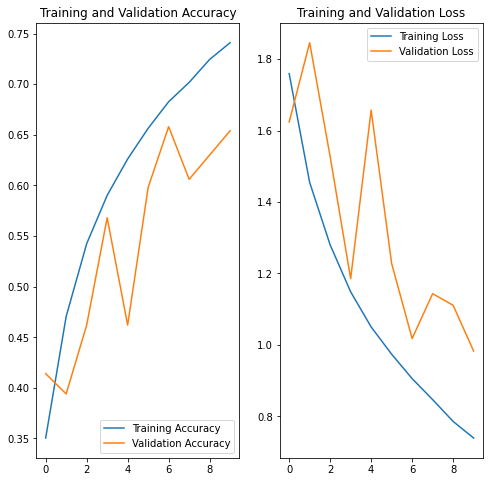

In [ ]:
import matplotlib.pyplot as plt

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(10)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()